In [25]:
import os
import pandas as pd

In [3]:
def process_log_easy(file="data_logs_players/log_1_easy.csv"):
    df = pd.read_csv(file)
    results = df.at[len(df)-1, "Unnamed: 0"].split()  # result logged as "Killed: X Saved: Y" in first column
    killed, saved = map(int, [results[1], results[3]])
    df = df.drop(["Unnamed: 0", "humanoid_fp", "humanoid_probs", "local_run_id"], axis=1)
    df = df.dropna()
    return df, killed, saved

In [4]:
def process_log_hard(file="data_logs_players/log_2_hard.csv"):
    df = pd.read_csv(file)
    results = df.at[len(df)-1, "Unnamed: 0"].split()  # result logged as "Killed: X Saved: Y" in first column
    killed, saved = map(int, [results[1], results[3]])
    df = df.drop(["Unnamed: 0", "humanoid_fp", "local_run_id"], axis=1)
    df = df.dropna()
    df["highest_prob"] = df["humanoid_probs"]
    df["highest_prob"] = df["highest_prob"].map(eval)
    df["highest_prob"] = df["highest_prob"].map(lambda d: sorted(d, key=lambda x: d[x], reverse=True)[0])
    return df, killed, saved

In [16]:
def get_combined_data(folder):
    easy_scores, hard_scores = [], []
    easy_data, hard_data = pd.DataFrame(), pd.DataFrame()
    for file in os.listdir(folder):
        if "easy" in file:
            log, killed, saved = process_log_easy(os.path.join(folder, file))
            easy_data = pd.concat([easy_data, log])
            easy_scores.append((killed, saved))
        elif "hard" in file:
            log, killed, saved = process_log_hard(os.path.join(folder, file))
            hard_data = pd.concat([hard_data, log])
            hard_scores.append((killed, saved))
    return easy_scores, hard_scores, easy_data, hard_data


In [17]:
es, hs, ed, hd = get_combined_data("data_logs_players")

In [77]:
# can we even get useful info out of this :P

easy_scores = sorted([s - k for (k, s) in es])
hard_scores = sorted([s - k for (k, s) in hs])

print(easy_scores)
print(pd.Series(easy_scores).describe())
print()
print(hard_scores)
print(pd.Series(hard_scores).describe())

[-20, -13, 2, 12, 13, 16]
count     6.000000
mean      1.666667
std      15.002222
min     -20.000000
25%      -9.250000
50%       7.000000
75%      12.750000
max      16.000000
dtype: float64

[-12, -7, 0, 6, 9, 10, 11]
count     7.000000
mean      2.428571
std       9.034326
min     -12.000000
25%      -3.500000
50%       6.000000
75%       9.500000
max      11.000000
dtype: float64


Matplotlib is building the font cache; this may take a moment.


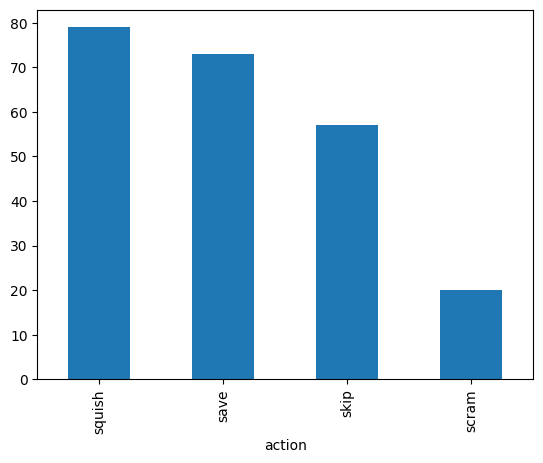

In [26]:
action_dist_easy = ed["action"].value_counts()
ax = action_dist_easy.plot.bar()

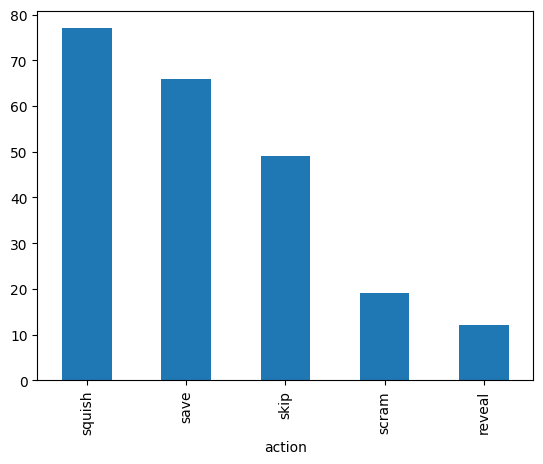

In [27]:
action_dist_hard = hd["action"].value_counts()
ax = action_dist_hard.plot.bar()

<Axes: >

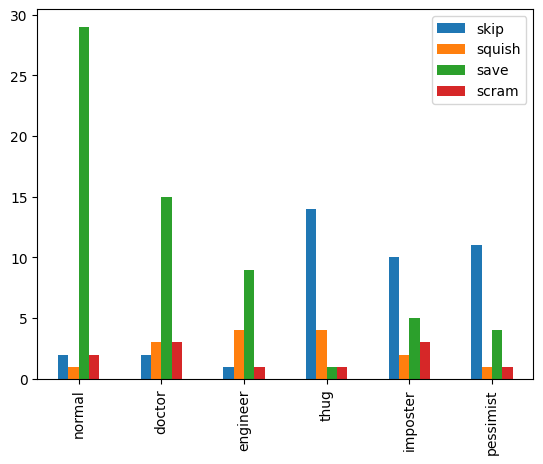

In [63]:
# action distribution by job (human, easy)
human_action_dist_easy = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram"])
for action in ed.itertuples(index=False):
    if action.humanoid_class == "healthy":
        human_action_dist_easy.loc[action.humanoid_job, action.action] += 1

human_action_dist_easy.plot.bar()

<Axes: >

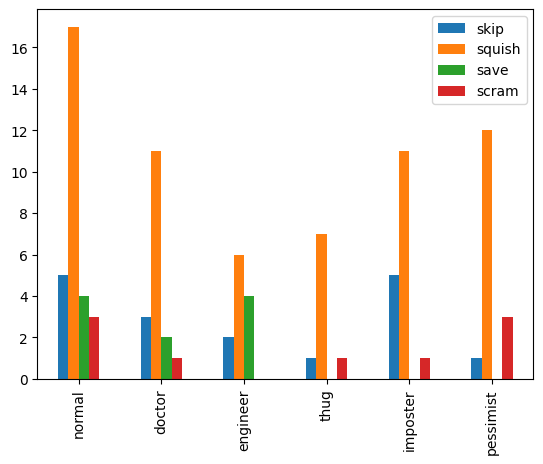

In [64]:
# same but for zombies 
zombie_action_dist_easy = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram"])
for action in ed.itertuples(index=False):
    if action.humanoid_class == "zombie":
        zombie_action_dist_easy.loc[action.humanoid_job, action.action] += 1

zombie_action_dist_easy.plot.bar()

<Axes: >

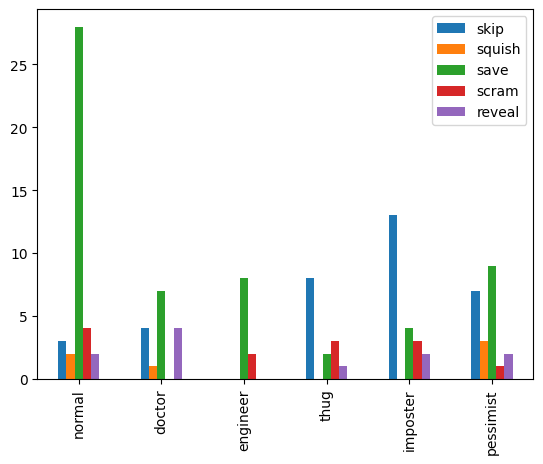

In [78]:
# action distribution by job (human, hard)
human_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    if action.humanoid_class == "healthy":
        human_action_dist_hard.loc[action.humanoid_job, action.action] += 1

human_action_dist_hard.plot.bar()

<Axes: >

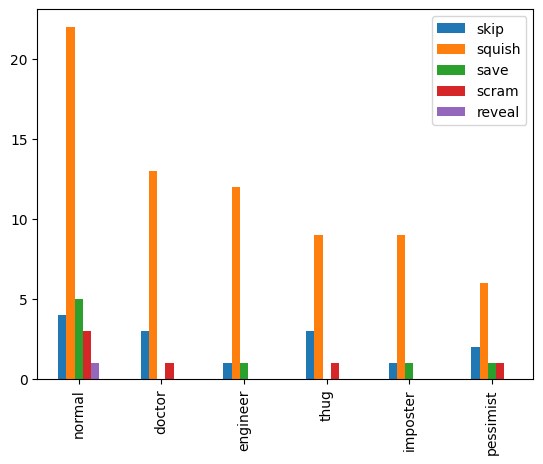

In [79]:
# same but for zombies 
zombie_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    if action.humanoid_class == "zombie":
        zombie_action_dist_hard.loc[action.humanoid_job, action.action] += 1

zombie_action_dist_hard.plot.bar()

<Axes: >

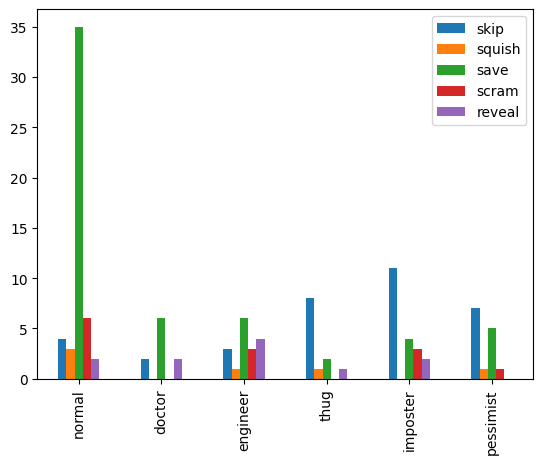

In [83]:
# action distribution by highest prob (human, hard)
human_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    # print(action)
    if action.humanoid_class == "healthy":
        human_action_dist_hard.loc[action.highest_prob, action.action] += 1

human_action_dist_hard.plot.bar()